In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from configparser import ConfigParser

import numpy as np
import torch
from easydict import EasyDict
from pytorch_lightning import seed_everything
from tqdm.contrib import tenumerate

from models.protoconv.comet_connector import CometConnector

warnings.simplefilter("ignore")
seed_everything(0)

Global seed set to 0


0

In [29]:
@torch.no_grad()
def calc_decision_flips(model, val_loader, iterations=3):
    context = model.conv_filter_size // 2
    decision_flips = [0] * iterations
    all_tests = 0

    for batch_id, (text, label) in tenumerate(val_loader, total=len(val_loader)):
        first_decision = model(text).logits.item() > 0
        all_tests += 1

        changed_flag = False

        for test_id in range(iterations):
            if changed_flag:
                decision_flips[test_id] += 1
            else:
                output = model(text)
                similarities = model.dist_to_sim['log'](output.min_distances.squeeze(0))
                evidence = similarities * model.fc1.weight.squeeze(0)
                sorting_indexes = np.argsort(evidence.tolist())
                enabled_prototypes_indexes = [i for i in sorting_indexes if model.enabled_prototypes_mask[i]]

                if first_decision:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes[::-1] if evidence[i] > 0]
                else:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes if evidence[i] < 0]

                for concept_to_remove in prototypes_to_remove:

                    unk_in_text = 0
                    for i in range(text.shape[1]):
                        if text[0,i] == TEXT.vocab.stoi['<unk>']:
                            unk_in_text+=1
                    if unk_in_text + 4 >= text.shape[1]:
                        break

                    center = torch.argmin(output.distances[0, concept_to_remove]).item()
                    for word_idx in range(center - context, center + context + 1):
                        if 1 <= word_idx <= len(text[0]) - 2:  # dont remove start and stop:
                            text[0, word_idx] = TEXT.vocab.stoi['<unk>']

                    preds = model(text)
                    decision = preds.logits.item() > 0

                    if first_decision != decision:
                        changed_flag = True
                        decision_flips[test_id] += 1
                        break
    print(all_tests)
    for test_id in range(iterations):
        decision_flips[test_id] /= all_tests

    return decision_flips

In [30]:
config = ConfigParser()
config.read('../config.ini')
comet_config = EasyDict(config['cometml'])
commet_connector = CometConnector(comet_config.apikey, comet_config.projectname, comet_config.workspace, rel_path='..')

experimetns_5gram = {
    'imdb': 'abc1851dba1c46f28e16ddd90ec9c3e6',
    'amazon': 'e81f6bb0081f459c8e5c2b42cae6a2ea',
    'yelp': '26daecaeebd246a9ac9c14bdbafcc1fe',
    'rottentomatoes': '6b4aef88e5144aa396f4eef98490e3a7',
    'hotel': '9378a9ae08c64f96a2e6fabcdc33fa3c'
}

flips_per_ds={}
iterations=5
for ds_name, experiment_id in experimetns_5gram.items():
    commet_connector.set_experiment(experiment_id, rel_path='..')
    commet_connector.get_model()
    model = commet_connector.model.cuda()
    model.eval()
    train_loader, val_loader, TEXT = commet_connector.train_loader, commet_connector.val_loader, commet_connector.TEXT
    flips_per_ds[ds_name] = calc_decision_flips(model, val_loader, iterations=iterations)

flips_per_ds

COMET INFO: Downloading experiment model 'fold_0_epoch=10-val_loss_0=0.3934-val_acc_0=0.8588.ckpt' ...
COMET INFO: Unzipping model to 'checkpoints/' ...
COMET INFO: done!



5000


COMET INFO: Downloading experiment model 'fold_0_epoch=05-val_loss_0=0.3417-val_acc_0=0.8853.ckpt' ...
COMET INFO: Unzipping model to 'checkpoints/' ...
COMET INFO: done!



6000


COMET INFO: Downloading experiment model 'fold_0_epoch=10-val_loss_0=0.4223-val_acc_0=0.8363.ckpt' ...
COMET INFO: Unzipping model to 'checkpoints/' ...
COMET INFO: done!



6000


COMET INFO: Downloading experiment model 'fold_0_epoch=12-val_loss_0=0.6212-val_acc_0=0.7325.ckpt' ...
COMET INFO: Unzipping model to 'checkpoints/' ...
COMET INFO: done!



6000


COMET INFO: Downloading experiment model 'fold_0_epoch=14-val_loss_0=0.3432-val_acc_0=0.8979.ckpt' ...
COMET INFO: Unzipping model to 'checkpoints/' ...
COMET INFO: done!



950


AttributeError: 'dict' object has no attribute 'head'

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

flips_col_name = 'Percentage of decisions changed'
phrases_col_name = 'Number of iterations'
dataset_col_name = 'Dataset'

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_rows', 110)

In [32]:
data = [[ds, prots,percent] for ds, flips in flips_per_ds.items() for prots, percent in zip(range(1, iterations+1), flips)]
df = pd.DataFrame(data, columns=[dataset_col_name,phrases_col_name,flips_col_name])
df.to_csv('fidelity_data.csv')
df.head()


,Dataset,Number of iterations,Percentage of decisions changed
0,imdb,1,0.4502
1,imdb,2,0.7656
2,imdb,3,0.9152
3,imdb,4,0.9690
4,imdb,5,0.9880


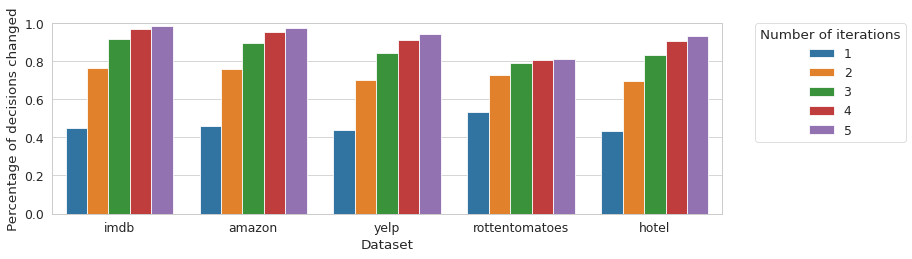

In [39]:
plt.figure(figsize=(12,3.5))
ax = sns.barplot(x=dataset_col_name, y=flips_col_name, hue=phrases_col_name, data=df, palette=sns.color_palette('tab10'))
plt.ylim(0,1)
plt.legend(title=phrases_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
plt.close()

In [36]:
plt.figure(figsize=(12,3.5))
ax = sns.barplot(x=dataset_col_name, y=flips_col_name, hue=phrases_col_name, data=df, palette=sns.color_palette('tab10'))
plt.ylim(0,1)
plt.legend(title=phrases_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fidelity.png', bbox_inches='tight', dpi=300)
plt.close()

###  Line Plot


In [37]:
zeros = [[ds, 0, 0] for ds, _ in flips_per_ds.items()]
data2 = data + zeros
df2 = pd.DataFrame(data2, columns=[dataset_col_name,phrases_col_name,flips_col_name])
df2.to_csv('fidelity_lineplot_data.csv')
df2.head()

,Dataset,Number of iterations,Percentage of decisions changed
0,imdb,1,0.4502
1,imdb,2,0.7656
2,imdb,3,0.9152
3,imdb,4,0.9690
4,imdb,5,0.9880


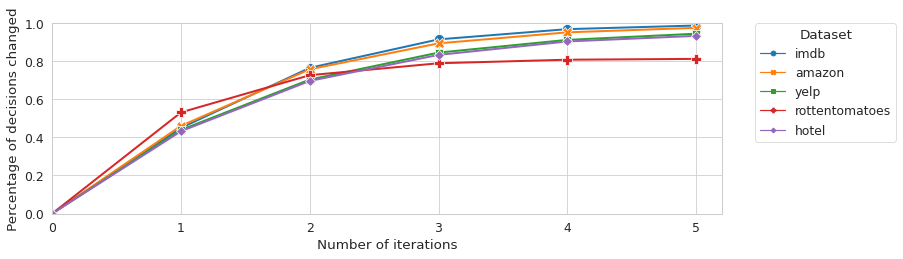

In [7]:
df2=pd.read_csv('fidelity_lineplot_data.csv')
plt.figure(figsize=(12,3.5))
sns.lineplot(x=phrases_col_name, y=flips_col_name, hue=dataset_col_name, data=df2, markers=True,dashes=False, style=dataset_col_name, linewidth=2, markersize=10)
plt.ylim(0,1)
plt.xlim(0,5.2)
plt.legend(title=dataset_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fidelity_line.png', bbox_inches='tight', dpi=300)

